## Calculating Value at Risk (VaR) of a Stock Portfolio

VaR is used to quantify the level of financial risk over a specified time frame. 

Estimate of the maximum loss from a given position or portfolio over a period of time.
e.g. "We have a portfolio VaR of 250,000 USD over the next month at 95% confidence. We can say with 95% confidence the Portfolio's loss will not exceed 250,000 USD in a month."


2 main methods:
- Monte Carlo
- Variance-covariance

**Variance-Covariance**
Looks at historical price movements (standard deviation, mean price) of an equity or portfolio of equities over a specified look back theory. Then uses probability theory to calculate the maximum loss within the specified confidence interval.

Note: assumes a normal distribution
Note: Best used in standard market conditions, not well-suited to extreme / outlier events

**Steps to Calculating VaR**

1. Calculate periodic returns (the percentage change in the value of an assessment)
2. Create a covariance matrix based on returns
3. Calculate portfolio mean and standard deviation (weight based on investment levels of each stock in the portfolio)
4. Calculate the inverse of the normal cumulative distribution (PpF) with a specified confidence interval, standard deviation and mean.
5. Estimate the VaR by subtracting the initial investment from the calculation in step 4

In [8]:
import pandas as pd
from pandas_datareader import data as pdr
import fix_yahoo_finance as yf
import numpy as np
import datetime as dt

In [7]:
#Create portfolio of equities
tickers = ['SSE.L', 'EDF.PA', 'ORSTED.CO', 'AAPL']

#Set investment weights for each ticker
weights = np.array([.25, .25, .25, .25])

#Set an initial investment level
initial_investment = 1000000

#download closing prices
data = pdr.get_data_yahoo(tickers, start="2018-01-01", end=dt.date.today())['Close']

#Using the closing prices, calculate the periodic returns
#pct_change() calculates the percentage change between the current and the prior element in a df
returns = data.pct_change()

returns.tail()

Symbols,SSE.L,EDF.PA,ORSTED.CO,AAPL
Date,,,,
2021-07-26,0.001314,-0.000922,-0.002118,0.002895
2021-07-27,0.001969,0.002768,-0.010823,-0.014900
2021-07-28,0.004257,-0.003220,0.026604,-0.012196
2021-07-29,-0.039778,-0.034610,-0.013584,0.004552
2021-07-30,-0.018336,-0.018642,-0.013347,0.001511


## 2. Create a Covariance Matrix for Each Stock
Covariance is the mean value of the product of the deviations of two variables from their respective means
xi is the data value of x
yi is the data value of y
xhat is the mean of x
yhat is the mean of y
N = nuber of data values

![Alt text](https://www.gstatic.com/education/formulas2/355397047/en/covariance_formula.svg)

In [9]:
#Generate a covariance matrix based on the returns
cov_matrix = returns.cov()
cov_matrix

Symbols,SSE.L,EDF.PA,ORSTED.CO,AAPL
Symbols,,,,
SSE.L,0.000336,0.000192,0.000145,0.000096
EDF.PA,0.000192,0.000506,0.000136,0.000095
ORSTED.CO,0.000145,0.000136,0.000324,0.000076
AAPL,0.000096,0.000095,0.000076,0.000445


## 3. Calculate the Portfolio Mean and the Standard Deviation

The dot product relies on:
a · b = ax × bx + ay × by

![ChessUrl](https://www.mathsisfun.com/algebra/images/dot-product-2.gif "chess")


In [30]:
avg_rets = returns.mean()
print("Average Returns for Each Stock:","\n", avg_rets)

#Calculate mean returns for portfolio overall using the dot product to normalize individual means 
#against investment weights
port_mean = avg_rets.dot(weights)
print("Mean Return for Overall Portfolio", port_mean)

#Calculate standard deviation of Portfolio
#.T is the transport of the array
port_stdev = np.sqrt(weights.T.dot(cov_matrix).dot(weights))
print("Portfolio Standard Deviation is:", port_stdev)

#Calculate the mean of investment
mean_investment = (1+port_mean) * initial_investment
print("Mean Investment of the Portfolio is:", mean_investment)

#Calculate standard deviation of the investment
stdev_investment = initial_investment * port_stdev
print("Standard Deviation of the Investment is:", stdev_investment)

Average Returns for Each Stock: 
 Symbols
SSE.L        0.000284
EDF.PA       0.000228
ORSTED.CO    0.001259
AAPL         0.001544
dtype: float64
Mean Return for Overall Portfolio 0.0008287424724943478
Portfolio Standard Deviation is: 0.013904199251941406
Mean Investment of the Portfolio is: 1000828.7424724944
Standard Deviation of the Investment is: 13904.199251941405


## 4. Calculate the Inverse of the Normal Cumulative Distribution (PPF) With a Specified Confidence Interval

In [32]:
#Set a confidence level (95% confidence level)
conf_level1 = 0.05
#Use scipy ppf to generate values for the inverse cumulative distribution function to a normal
#distribution
from scipy.stats import norm
cutoff1 = norm.ppf(conf_level1, mean_investment, stdev_investment)
print(cutoff1)

977958.3699030826


## 5. Estimate the Value at Risk (VaR)
Do so by subtracting the inverse of the normal cumulative distribution (PPF) from the initial investment

In [38]:
var_1d1 = initial_investment - cutoff1
print(type(var_1d1))
print("The VaR is", var_1d1)
#Here we are saying with 95% conifdence that our portfolio of 1M USD that our portfolio will not exceed losses
#greater than 22.3k USD over a one day period

<class 'numpy.float64'>
The VaR is 22041.63009691739


## Calculating VaR Over an N-Day Time Period
We can calculate the VaR over a larger window of time by taking our 1 day VaR and multiplying it by the square root of the time period (as the standard deviation of stock returns tends to increase with the square root of time)

1 day VaR @ 95% confidence: 22041.63
2 day VaR @ 95% confidence: 31171.57
3 day VaR @ 95% confidence: 38177.22
4 day VaR @ 95% confidence: 44083.26
5 day VaR @ 95% confidence: 49286.58
6 day VaR @ 95% confidence: 53990.75
7 day VaR @ 95% confidence: 58316.67
8 day VaR @ 95% confidence: 62343.14
9 day VaR @ 95% confidence: 66124.89
10 day VaR @ 95% confidence: 69701.75


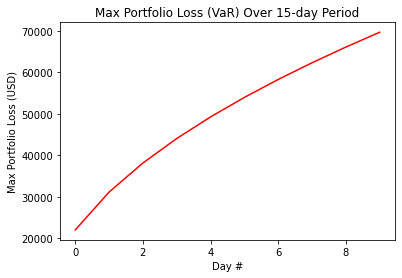

In [42]:
var_array = []
num_days = int(10)

for x in range (1, num_days+1):
    var_array.append(np.round(var_1d1*np.sqrt(x), 2))
    print(str(x) + " day VaR @ 95% confidence: " + str(np.round(var_1d1 * np.sqrt(x) ,2)))

#Build a plot
import matplotlib.pyplot as plt
plt.xlabel("Day #")
plt.ylabel("Max Portfolio Loss (USD)")
plt.title("Max Portfolio Loss (VaR) Over 15-day Period")
plt.plot(var_array, "r")

## Do Distributions of our Equities Match a Normal Distribution?

We can check whether historical returns have been distributed to help assess whether VaR is suitable


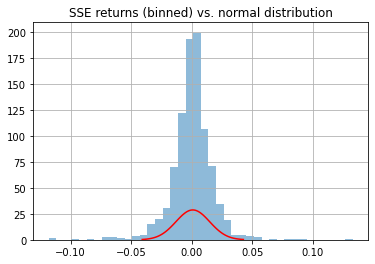

In [48]:
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import scipy

returns['SSE.L'].hist(bins=40, histtype="stepfilled",alpha=0.5)
x = np.linspace(port_mean - 3*port_stdev, port_mean+3*port_stdev,100)
plt.plot(x, scipy.stats.norm.pdf(x, port_mean, port_stdev), "r")
plt.title("SSE returns (binned) vs. normal distribution")
plt.show()